In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()

sc.settings.set_figure_params(dpi=80)
%matplotlib inline

In [2]:
# Load the stored data object
save_file = './data/results/scanpy_dr_covid.h5ad'
adata = sc.read_h5ad(save_file)

In [3]:
print(adata.X.shape)

(5589, 3058)


In [4]:
adata2 = adata.raw.to_adata() 

# check that the matrix looks like noramlized counts
print(adata2.X[1:10,1:10])

  (0, 5)	0.9678403
  (1, 5)	0.5124039


### 1. Detect variable genes 

In [5]:
var_genes_all = adata.var.highly_variable

print("Highly variable genes: %d"%sum(var_genes_all))

Highly variable genes: 3058


In [6]:
sc.pp.log1p(adata2)

In [7]:
sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key = 'sample')

print("Highly variable genes intersection: %d"%sum(adata2.var.highly_variable_intersection))

print("Number of batches where gene is variable:")
print(adata2.var.highly_variable_nbatches.value_counts())

var_genes_batch = adata2.var.highly_variable_nbatches > 0

extracting highly variable genes


C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:478: FutureWarning: The frame.append meth

    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Highly variable genes intersection: 378
Number of batches where gene is variable:
0    12216
1     3112
2     1526
3      787
4      423
6      378
5      310
Name: highly_variable_nbatches, dtype: int64


C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)


In [8]:
print("Any batch var genes: %d"%sum(var_genes_batch))
print("All data var genes: %d"%sum(var_genes_all))
print("Overlap: %d"%sum(var_genes_batch & var_genes_all))
print("Variable genes in all batches: %d"%sum(adata2.var.highly_variable_nbatches == 6))
print("Overlap batch instersection and all: %d"%sum(var_genes_all & adata2.var.highly_variable_intersection))

Any batch var genes: 6536
All data var genes: 3058
Overlap: 2589
Variable genes in all batches: 378
Overlap batch instersection and all: 298


In [9]:
var_select = adata2.var.highly_variable_nbatches > 2
var_genes = var_select.index[var_select]
len(var_genes)

1898

### 2. Data integration

In [10]:
# split per batch into new objects.
batches = adata.obs['sample'].cat.categories.tolist()
alldata = {}
for batch in batches:
    alldata[batch] = adata2[adata2.obs['sample'] == batch,]

alldata    

{'covid_1': View of AnnData object with n_obs × n_vars = 855 × 18752
     obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
     var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
     uns: 'doublet_info_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'sample_colors', 'tsne', 'umap'
     obsm: 'X_pca', 'X_tsne', 'X_umap'
     obsp: 'connectivities', 'distances',
 'covid_15': View of AnnData object with n_obs × n_vars = 582 × 18752
     obs: 'type', 'sample', 'batch', 'n_genes_by_counts',

In [12]:
cdata = sc.external.pp.mnn_correct(alldata['covid_1'],alldata['covid_15'],alldata['covid_17'],
                                   alldata['ctrl_5'],alldata['ctrl_13'],alldata['ctrl_14'], 
                                   svd_dim = 50, batch_key = 'sample', save_raw = True, var_subset = var_genes)

C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\mnnpy\utils.py:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "l2_norm" failed type inference due to: No implementation of function Function(<function norm at 0x000001417F73C310>) found for signature:
 
 >>> norm(x=array(float32, 2d, A), axis=Literal[int](1))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'norm_impl': File: numba\np\linalg.py: Line 2351.
    With argument(s): '(x=array(float32, 2d, A), axis=int64)':
   Rejected as the implementation raised a specific error:
     TypingError: missing a required argument: 'a'
  raised from C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\numba\core\typing\templates.py:791

During: resolving callee type: Function(<function norm at 0x000001417F73C310>)
During: typing of call at C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\mnnpy\utils.py (16)


File "..\..\..\anaconda3\lib\

C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\mnnpy\utils.py:199: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "adjust_s_variance" failed type inference due to: NameError: name 'sq_dist_to_line' is not defined
  @jit(float32(float32[:, :], float32[:, :], float32[:], float32[:], float32), nogil=True)
C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\mnnpy\utils.py:199: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "adjust_s_variance" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "..\..\..\anaconda3\lib\site-packages\mnnpy\utils.py", line 207:
def adjust_s_variance(data1, data2, curcell, curvect, sigma):
    <source elided>
    totalprob2 = 0.
    for samecell in data2:
    ^

  @jit(float32(float32[:, :], float32[:, :], float32[:], float32[:], float32), nogil=True)
C:\Users\Mujtaba Barci\anaconda3\lib\site-p

Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 5: processing batch 1
  Looking for MNNs...


C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\mnnpy\utils.py:88: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "find_mutual_nn" failed type inference due to: non-precise type pyobject
During: typing of argument at C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\mnnpy\utils.py (94)

File "..\..\..\anaconda3\lib\site-packages\mnnpy\utils.py", line 94:
def find_mutual_nn(data1, data2, k1, k2, n_jobs):
    <source elided>
    mutual_2 = []
    for index_2 in range(data2.shape[0]):
    ^

  @jit((float32[:, :], float32[:, :], int8, int8, int8))
C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "find_mutual_nn" was compiled in object mode without forceobj=True.

File "..\..\..\anaconda3\lib\site-packages\mnnpy\utils.py", line 94:
def find_mutual_nn(data1, data2, k1, k2, n_jobs):
    <source elided>
    mutual_2 = []
    for index_2 in range(data2.shape[0]):
    ^

  

  Computing correction vectors...


C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\mnnpy\utils.py:102: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "compute_correction" failed type inference due to: non-precise type pyobject
During: typing of argument at C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\mnnpy\utils.py (107)

File "..\..\..\anaconda3\lib\site-packages\mnnpy\utils.py", line 107:
def compute_correction(data1, data2, mnn1, mnn2, data2_or_raw2, sigma):
    <source elided>
    vect_reduced = np.zeros((data2.shape[0], vect.shape[1]), dtype=np.float32)
    for index, ve in zip(mnn2, vect):
    ^

  @jit(float32[:, :](float32[:, :], float32[:, :], int32[:], int32[:], float32[:, :], float32))
C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "compute_correction" was compiled in object mode without forceobj=True.

File "..\..\..\anaconda3\lib\site-packages\mnnpy\utils.py", line 107:
def compu

  Removing components...
  Adjusting variance...
  Applying correction...
Step 2 of 5: processing batch 2
  Looking for MNNs...
  Computing correction vectors...
  Removing components...
  Adjusting variance...
  Applying correction...
Step 3 of 5: processing batch 3
  Looking for MNNs...
  Computing correction vectors...
  Removing components...
  Adjusting variance...
  Applying correction...
Step 4 of 5: processing batch 4
  Looking for MNNs...
  Computing correction vectors...
  Removing components...
  Adjusting variance...
  Applying correction...
Step 5 of 5: processing batch 5
  Looking for MNNs...
  Computing correction vectors...
  Removing components...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...


C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\anndata\_core\anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


Done.


In [13]:
corr_data = cdata[0][:,var_genes]
corr_data.X.shape

(5589, 1898)

computing PCA
    with n_comps=50
    finished (0:00:05)


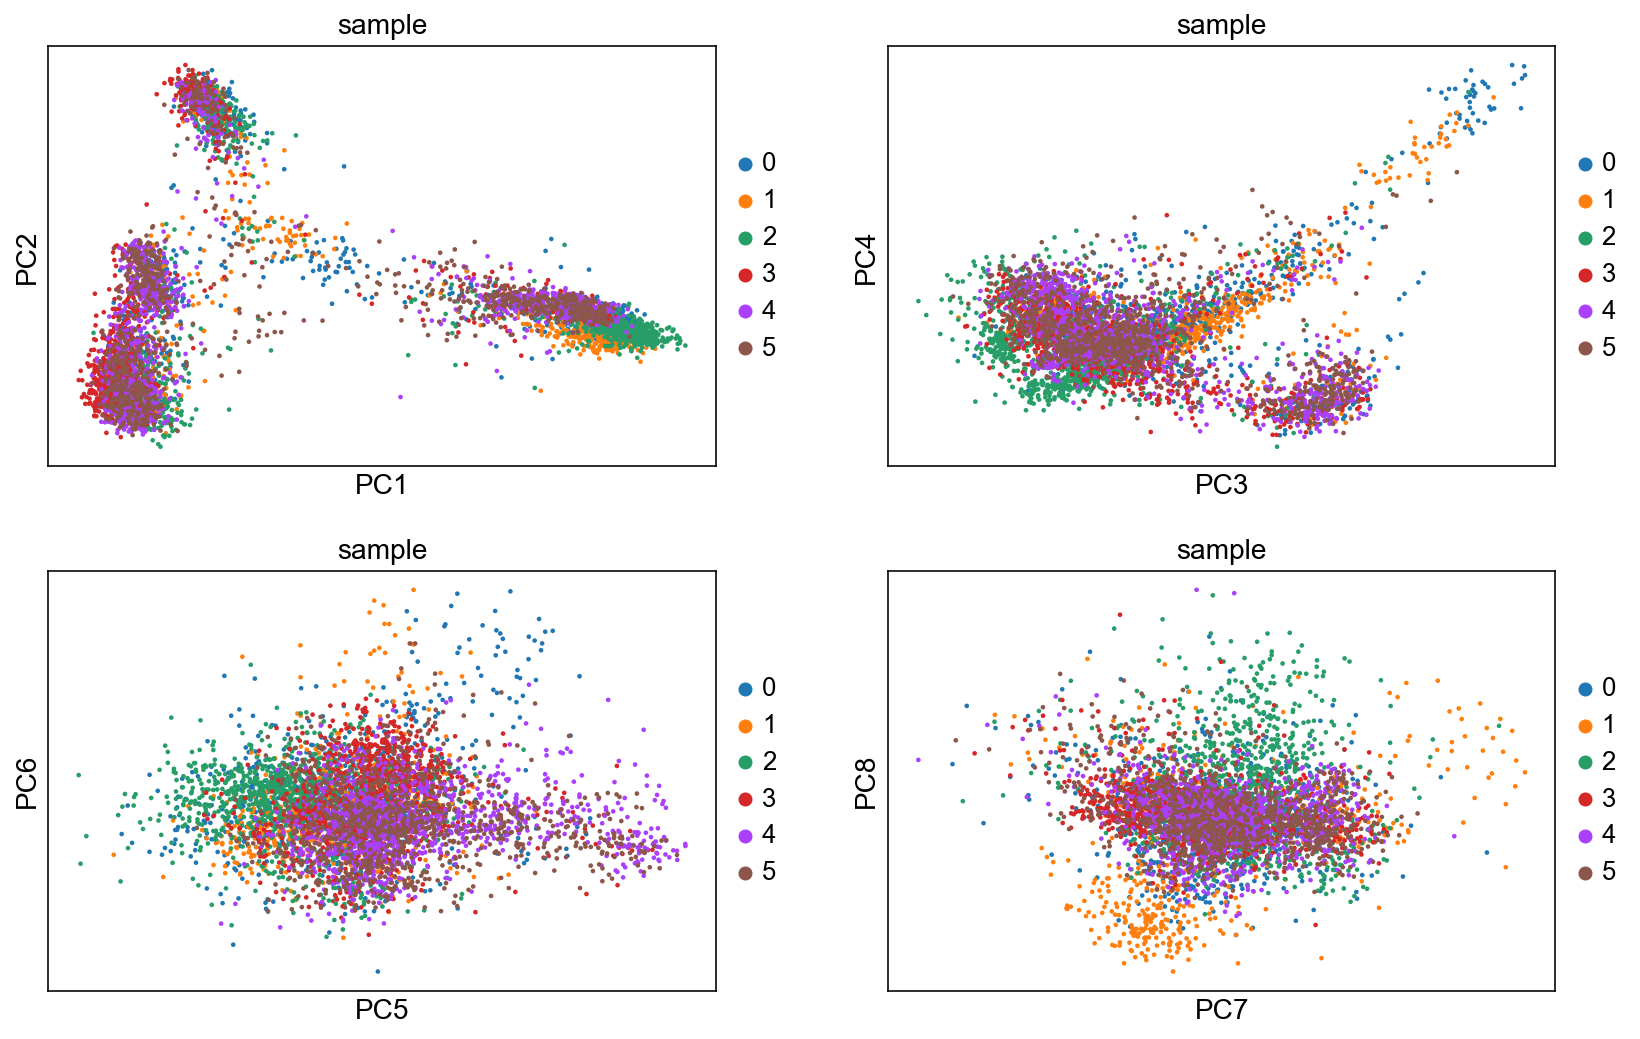

In [14]:
# run on all the genes in the dataset
sc.tl.pca(corr_data, svd_solver = 'arpack', use_highly_variable = False)
sc.pl.pca(corr_data, components = ['1,2','3,4','5,6','7,8'], ncols=2, color='sample')

In [ ]:
# tSNE
sc.tl.tsne(corr_data, n_pcs = 50)
# UMAP, first with neighbor calculation 
sc.pp.neighbors(corr_data, n_pcs = 50, n_neighbors = 20)
sc.tl.umap(corr_data)

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE


C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:01:01)
computing neighbors
    using 'X_pca' with n_pcs = 50


In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8,8),constrained_layout=True)
sc.pl.tsne(corr_data, color="sample", title="MNN Corrected tsne", ax=axs[0,0], show=False)
sc.pl.tsne(adata, color="sample", title="Uncorrected tsne", ax=axs[0,1], show=False)
sc.pl.umap(corr_data, color="sample", title="MNN Corrected umap", ax=axs[1,0], show=False)
sc.pl.umap(adata, color="sample", title="Uncorrected umap", ax=axs[1,1], show=False)